In [1]:
import os
import time
import sys

import numpy as np
import pylab as plt
import matplotlib as mpl
from scipy import stats

import pymc3 as pm
import theano
import theano.tensor as tt
from scipy.signal import savgol_filter

sys.path.append('/media/bigdata/firing_space_plot/ephys_data/')
import visualize as vz

from sklearn.decomposition import PCA

## Generate synthetic data

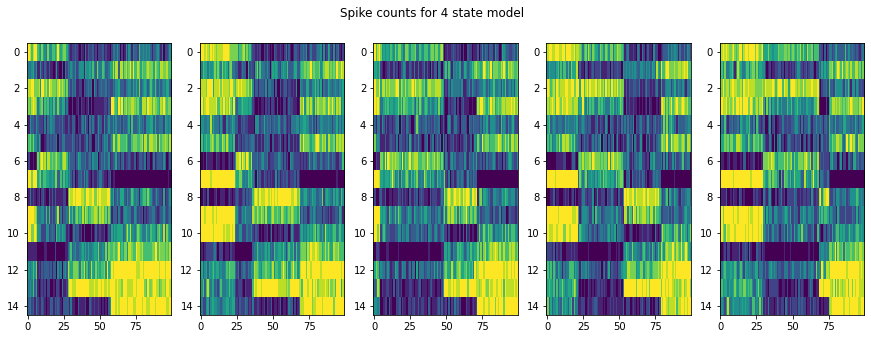

In [2]:
# Some poisson spiking
length = 1000
bin_width = 10
states = 4
nrns = 15
tastes = 4
trials = 20
idx = np.arange(length)

#true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau = np.cumsum(np.random.uniform(2,30, size = (tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)

true_lambda = np.random.random((tastes,nrns,states))

true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r   

# Spike array : tastes x trials x neurons x timebins
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array_long = np.concatenate(spike_array, axis=0) 

## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(spike_array[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

In [3]:
################
# Generate shuffled data
# Spike array : tastes x trials x neurons x timebins
inds = list(np.ndindex((data_array.shape[0], *data_array.shape[2:])))
shuffle_data = np.zeros(data_array.shape)

for this_ind in inds:
    shuffle_data[this_ind[0],:,this_ind[1], this_ind[2]] = np.random.permutation(data_array[this_ind[0],:,this_ind[1], this_ind[2]])
shuffle_spikes = np.sum(shuffle_data.reshape((*shuffle_data.shape[:3],-1,bin_width)),axis=-1)
shuffle_spikes = np.vectorize(np.int)(shuffle_spikes)    

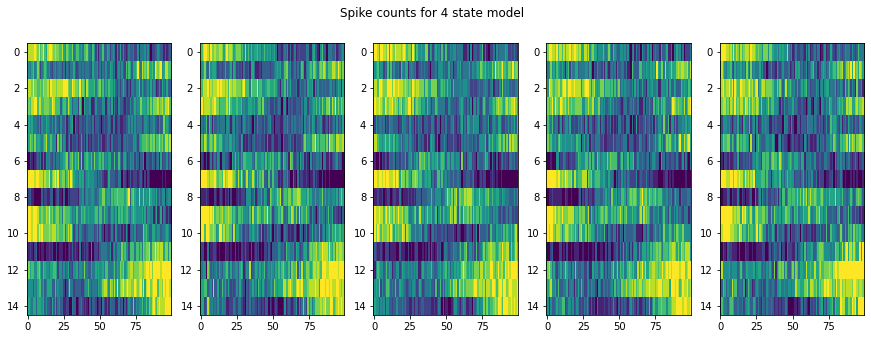

In [4]:
## Visualize some trials
taste_ind = 0
trial_count = 5

imshow_kwargs = dict(interpolation = 'nearest', aspect = 'auto')
fig,ax = plt.subplots(1,trial_count, figsize = (15,5))
for plot_dat, this_ax in zip(shuffle_spikes[taste_ind][:trial_count], ax.flatten()):
    this_ax.imshow(plot_dat, **imshow_kwargs)
plt.suptitle(f'Spike counts for {states} state model');

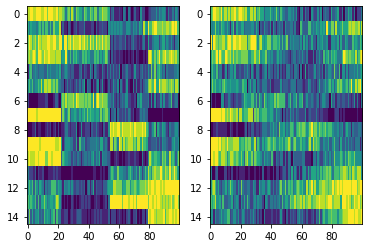

In [5]:
# Single neuron plots
fig,ax = plt.subplots(1,2)
taste_ind = 0
trial_ind = 3
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].imshow(spike_array[taste_ind,trial_ind], **img_kwargs)
ax[1].imshow(shuffle_spikes[taste_ind,trial_ind], **img_kwargs)

In [6]:
data_list = [spike_array[taste_ind,trial_ind], shuffle_spikes[taste_ind,trial_ind]]

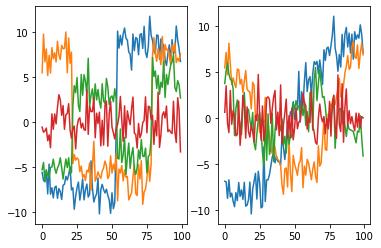

In [7]:
pca_list = [PCA(n_components = 4).fit_transform(x.T).T for x in data_list]
fig,ax = plt.subplots(1,2)
taste_ind = 0
trial_ind = 3
img_kwargs = dict(aspect='auto', interpolation='nearest')
ax[0].plot(pca_list[0].T)
ax[1].plot(pca_list[1].T)

In [137]:
pca_list[1].shape

(4, 100)

In [8]:
n_components = pca_list[0].shape[0]
n_neurons = 10
with pm.Model() as model:
    hyper_step = pm.Exponential("hyper_step", 0.05)
    step_size = pm.Exponential("step_size", hyper_step, shape = n_components)
    factors = pm.Deterministic('factors',
                               tt.stack([pm.GaussianRandomWalk(f"factor{i}", sigma=step_size[i], 
                        shape=length//bin_width) for i in range(n_components)]))
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 10, shape = (n_neurons, n_components))
    lambda_latent = pm.Deterministic('lambda_latent', tt.dot(proj_mat, factors))
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    prior_checks = pm.sample_prior_predictive(samples=1)
print(prior_checks['lambda_'].shape)
print(prior_checks['proj_mat'].shape)

(10, 100)
(10, 4)


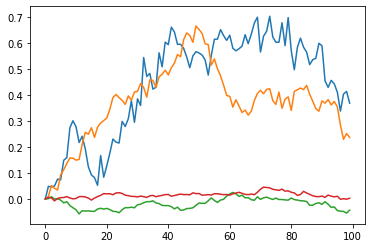

In [9]:
plt.plot(prior_checks['factors'].T);

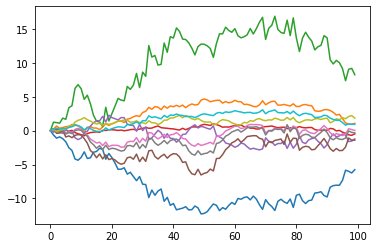

In [10]:
plt.plot(prior_checks['lambda_latent'].T);

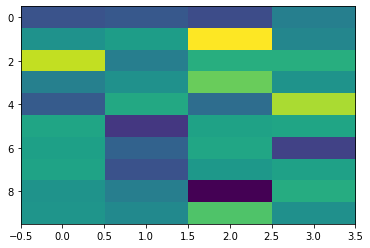

In [11]:
plt.imshow(prior_checks['proj_mat'], **img_kwargs)

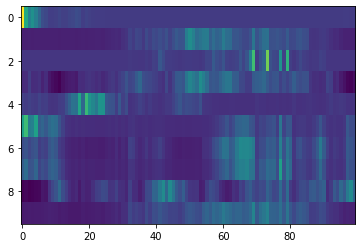

In [12]:
plt.imshow(stats.zscore(prior_checks['lambda_'], axis=-1), **img_kwargs)

In [14]:
n_components = pca_list[0].shape[0]
with pm.Model() as model:
    data = pm.Data('data', data_list[0])
    hyper_step = pm.Exponential("hyper_step", 0.05)
    step_size = pm.Exponential("step_size", hyper_step, shape = n_components)
    factors = pm.Deterministic('factors',
                               tt.stack([pm.GaussianRandomWalk(f"factor{i}", sigma=step_size[i], 
                            shape=length//bin_width, testval = pca_list[1][i]) for i in range(n_components)]))
    proj_mat = pm.Normal('proj_mat', mu = 0, sigma = 10, shape = (nrns, n_components))
    lambda_latent = pm.Deterministic('lambda_latent', tt.dot(proj_mat, factors))
    lambda_ = pm.Deterministic('lambda_', np.exp(lambda_latent))
    rate = pm.Poisson("rate", lambda_, observed=data)

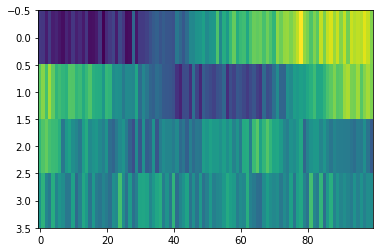

In [15]:
plt.imshow(model.factors.tag.test_value, **img_kwargs)

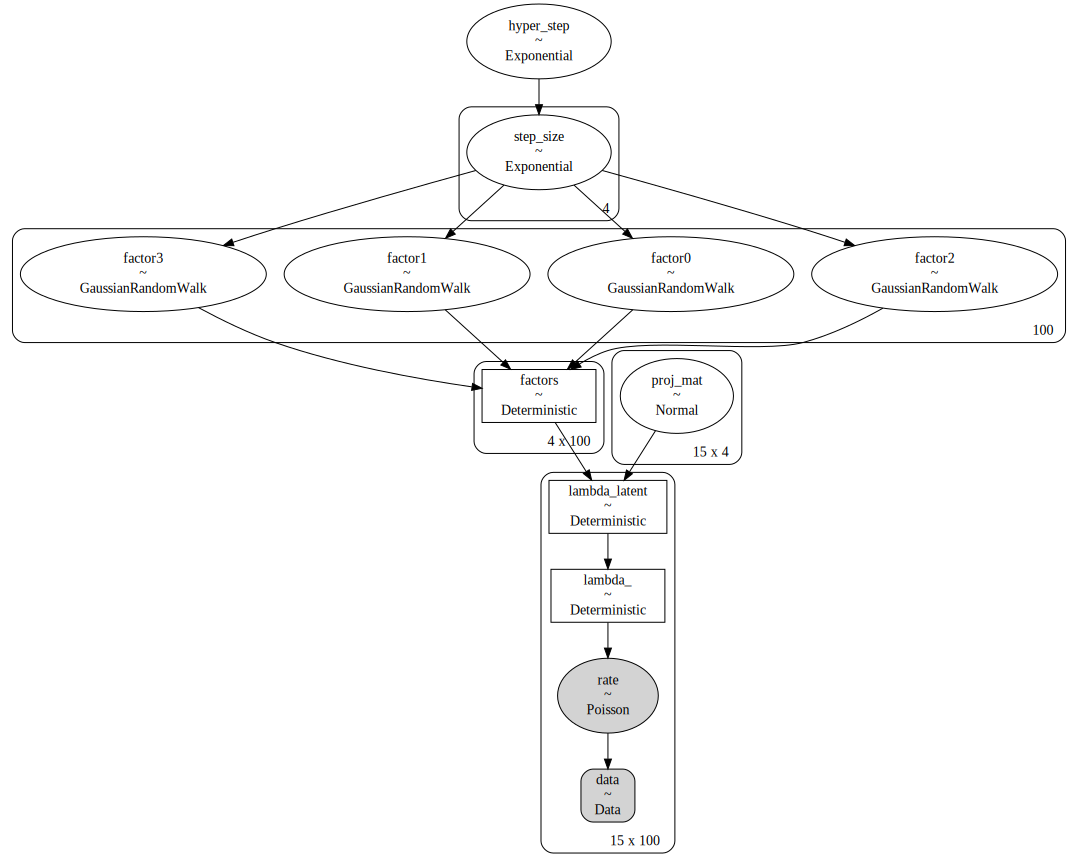

In [16]:
pm.model_to_graphviz(model)

In [17]:
trace_list = []
for this_data in data_list:
    with model:
        pm.set_data({'data': this_data})
        #trace = pm.sample()#step=pm.Metropolis())
        #trace_list.append(trace[::10])
    
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=40000, method=inference)
        trace = approx.sample(draws=2000)
        trace_list.append(trace[::10])

Finished [100%]: Average Loss = 3,318.6


Finished [100%]: Average Loss = 3,370.8


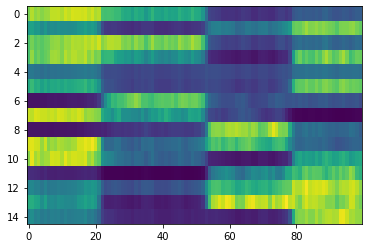

In [18]:
#plt.imshow(np.stack([trace_list[0][f'volatility{i}'].mean(axis=0) for i in range(trials)]), **img_kwargs)
plt.imshow(trace_list[0]['lambda_'].mean(axis=0), **img_kwargs)

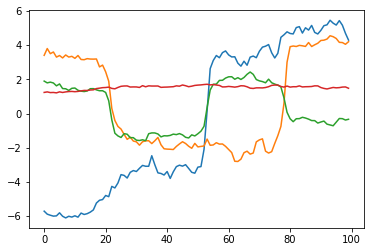

In [19]:
plt.plot(trace_list[0]['factors'].mean(axis=0).T)

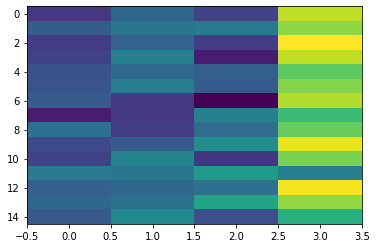

In [20]:
plt.imshow(trace_list[0]['proj_mat'].mean(axis=0), **img_kwargs)

In [21]:
ppc_list = [pm.sample_posterior_predictive(x, samples = 2000, model = model, var_names = ['lambda_']) for x in trace_list]

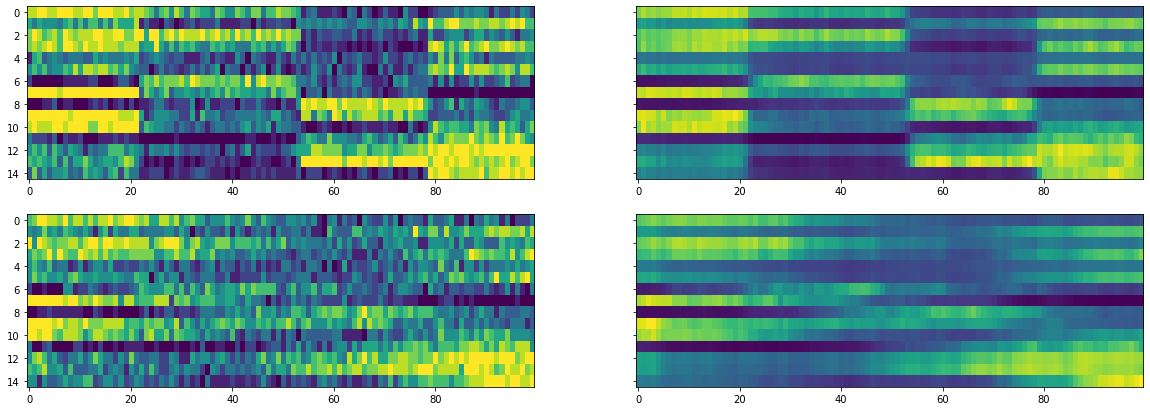

In [22]:
fig, ax = plt.subplots(2,2, figsize = (20,7), sharey = True)
ax[0,0].imshow(data_list[0], **img_kwargs)
ax[0,1].imshow(np.mean(ppc_list[0]['lambda_'],axis=0), **img_kwargs);

#==========================================================
ax[1,0].imshow(data_list[1], **img_kwargs)
ax[1,1].imshow(np.mean(ppc_list[1]['lambda_'],axis=0), **img_kwargs);

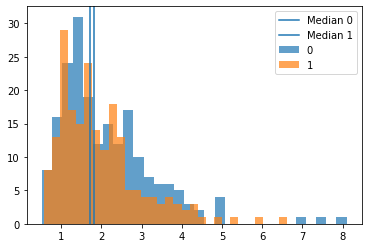

In [23]:
for num, this_trace in enumerate(trace_list):
    plt.hist(this_trace['hyper_step'], alpha = 0.7, label = str(num), bins = 30)
    plt.axvline(np.median(this_trace['hyper_step']), label = f'Median {num}')
plt.legend()